In [63]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from PIL import Image

In [64]:
class Picture():
    def __init__(self, url, x_dim=500, y_dim=500):
        '''
        Notes:
            - Large sigma values are better for more noise
            - Kernel size values are normally odd, larger values (>= 5) for stronger blur
            - OpenCV sets the kernel size as int(3*sigma), which is what is used here
            - PIL outputs image in RGB format
        '''
        self.url = url
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.have_intensities = False
        try:
            self.img = np.array(Image.open(url).resize((x_dim,y_dim)))
        except:
            print("Please make sure you are using a valid image")
        self.intensities = np.zeros((x_dim,y_dim))
        
    def _grayscale_simple(self):
        '''
        Fills in the intensity array with the average of each RGB value
        
        Returns: none
        '''
        if self.have_intensities:
            return
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                self.intensities[i][j] = np.full((1,3),np.mean(self.img[i][j]))
        self.have_intensities = True
    
    def _grayscale_luma(self):
        '''
        Fills in the intensity array using the Luma formula (based on the ITU-R BT.709 recommendation) 
        to correct for the human eye
        See: https://en.wikipedia.org/wiki/Rec._709

        Returns: none
        '''
        if self.have_intensities:
            return
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                tmp = self.img[i][j]
                self.intensities[i][j] = tmp[0]*0.2126+tmp[1]*0.7152+tmp[2]*0.0722
        self.have_intensities = True
    
    def _image_from_intensities(self):
        '''
        Returns: a numpy array of dimensions (self.x_dim, self.y_dim, 3) with the R, G, and B values at each pixel 
        being that of the intensity
        '''
        arr = np.zeros((self.x_dim,self.y_dim,3))
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                val = self.intensities[i][j]
                arr[i][j] = np.array([val,val,val])
        return arr
    
    def get_image(self):
        return self.img
    
    def get_intensities(self):
        if not self.have_intensities:
            self._grayscale_luma()
            self.have_intensities = True
        return self.intensities
    
    def show_image(self):
        image = Image.fromarray(self.img)
        display(image)
    
    def show_grayscale(self):
        if not self.have_intensities:
            self._grayscale_luma()
        image = Image.fromarray(self._image_from_intensities().astype(np.uint8))
        display(image)

    def show_image_from_intensities(self, intensities):
        image = Image.fromarray(intensities.astype(np.uint8))
        display(image)

In [65]:
tmp = Picture('steam_valve.png')

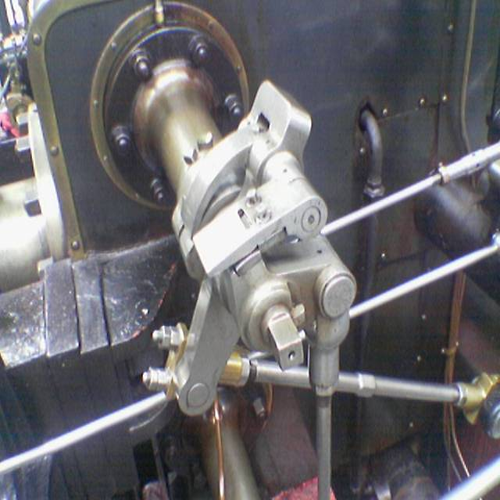

In [66]:
tmp.show_image()

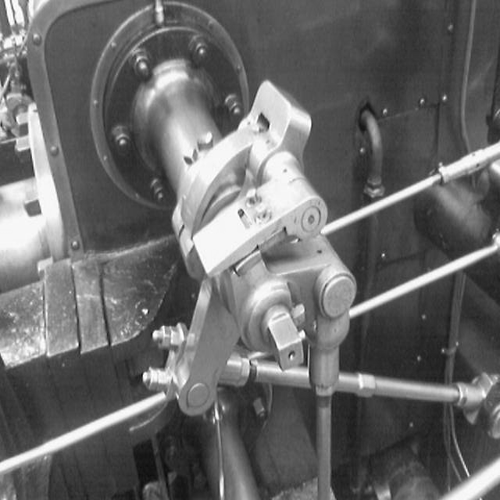

In [67]:
tmp.show_grayscale()

In [68]:
class Convolutor:
    '''
    Helper class to perform the convolution array*kernel
    '''
    def __init__(self, array, kernel):
        assert(len(kernel) == len(kernel[0])) # Ensure the kernel is valid
        self.array = array
        self.kernel = kernel
    
    def _pad_with(self, vector, pad_width, iaxis, kwargs):
        '''
        Helper function to pad arrays
        '''
        pad = kwargs.get('padder',0)
        vector[:pad_width[0]] = pad
        vector[-pad_width[1]:] = pad
    
    def _get_padded_array(self, array):
        '''
        Return a padded array for convenience for convolution
        '''
        return np.pad(array, len(self.kernel)//2, self._pad_with,padder=0)

    def get_convolution(self):
        '''
        Apply the convolution about the 2D Gaussian kernel of size self.kernel_size about array
        '''
        # TODO: Use FFT
        padded = self._get_padded_array(self.array)
        r = len(self.array)
        c = len(self.array[0])
        convoluted = np.zeros((r,c))
        for i in range(r):
            for j in range(c):
                for k in range(len(self.kernel)):
                    convoluted[i][j] += np.dot(self.kernel[k], padded[i+k][j:j+len(self.kernel)])
        return convoluted

In [69]:
class GaussianBlur:
    def __init__(self, sigma, kernel_size):
        '''
        Notes:
            - Large sigma values are better for more noise
            - Kernel size values are normally odd, larger values (>= 5) for stronger blur
            - OpenCV sets the kernel size as int(3*sigma)
        '''
        self.sigma = sigma
        self.kernel_size = kernel_size
    
    def _calculate_gaussian(self, x, y):
        scale = 1/(2*np.pi*self.sigma**2)
        exponent = np.exp(-(x**2+y**2)/(2*self.sigma**2))
        return scale*exponent

    def _get_kernel(self):
        '''
        Returns: 2D Gaussian kernel of size self.kernel_size
        '''
        sz = self.kernel_size
        center = sz//2
        kernel = np.zeros((sz,sz))
        for i in range(-center, center+1):
            for j in range(-center, center+1):
                kernel[i+center][j+center] = self._calculate_gaussian(i,j)
        kernel /= np.sum(kernel)
        return kernel

    def apply(self, image):
        '''
        Returns: Gaussian blurred image of intensities 
        '''
        arr = image.get_intensities()
        conv = Convolutor(arr,self._get_kernel())
        return conv.get_convolution()

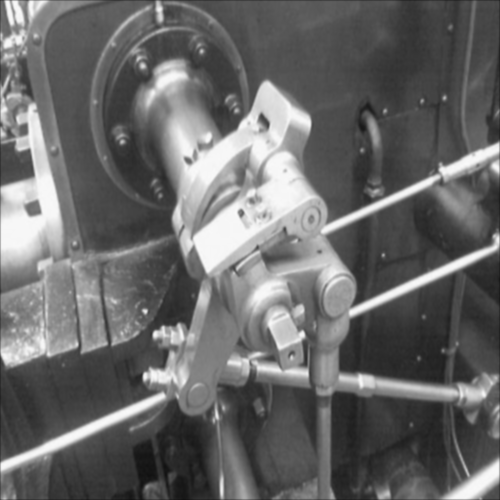

In [70]:
gb = GaussianBlur(0.84049642,9)
test = gb.apply(tmp)
tmp.show_image_from_intensities(test)

In [71]:
class GradientCalculator:
    '''
    Calculate the gradients using the sobel operator
    '''
    def __init__(self, array):
        self.x_grad = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
        self.y_grad = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
        self.array = array

    def _get_x_grad(self):
        convolutor = Convolutor(self.array, self.x_grad)
        return convolutor.get_convolution()

    def _get_y_grad(self):
        convolutor = Convolutor(self.array, self.y_grad)
        return convolutor.get_convolution()
    
    def get_magnitudes_and_angles(self):
        grad_x = self._get_x_grad()
        grad_y = self._get_y_grad()
        r = len(grad_x)
        c = len(grad_x[0])
        assert(r == len(grad_y) and c == len(grad_y[0])) # Ensure validity
        magnitudes = np.sqrt(np.square(grad_x)+np.square(grad_y))
        angles = np.arctan2(grad_y,grad_x)*180/np.pi
        return magnitudes, angles

In [72]:
gc = GradientCalculator(test)
m,a = gc.get_magnitudes_and_angles()

In [73]:
class NonMaximumSuppression:
    def __init__(self, magnitudes, angles):
        self.magnitudes = magnitudes
        self.angles = (angles+180)%180
    
    def binning(self):
        '''
        Returns an array of values in the range [0,3] responding to the direction of the edges
        These values correspond to:
            0: horizontal edges
            1: positive diagonal edges (45 degrees)
            2: vertical edges
            3: negative diagonal edges (other diagonal)
        '''
        binned_arr = np.zeros_like(self.angles)
        bins = [0, 45, 90, 135, 180]
        for i in range(4):
            binned_arr[np.logical_and(self.angles >= bins[i], self.angles < bins[i+1])] = i
        return binned_arr
    
    def apply_suppression(self):
        '''
        Apply the nonmaximum suppression: suppress gradient values that are not the local maxima (edges)
        For the border, it is common to set border values to 0
        '''
        suppressed = np.copy(self.magnitudes)
        bins = self.binning()
        for r in range(1, len(self.magnitudes)-1):
            for c in range(1, len(self.magnitudes[0])-1):
                bin_val = bins[r][c]
                if bin_val == 0: # Horizontal edge
                    if self.magnitudes[r][c] < self.magnitudes[r][c-1] or self.magnitudes[r][c] < self.magnitudes[r][c+1]:
                        suppressed[r][c] = 0
                elif bin_val == 1: # Positive diagonal
                    if self.magnitudes[r][c] < self.magnitudes[r-1][c-1] or self.magnitudes[r][c] < self.magnitudes[r+1][c+1]:
                        suppressed[r][c] = 0
                elif bin_val == 2: # Vertical edge
                    if self.magnitudes[r][c] < self.magnitudes[r-1][c] or self.magnitudes[r][c] < self.magnitudes[r+1][c]:
                        suppressed[r][c] = 0
                else: # Negative diagonal
                    if self.magnitudes[r][c] < self.magnitudes[r-1][c+1] or self.magnitudes[r][c] < self.magnitudes[r+1][c-1]:
                        suppressed[r][c] = 0
        
        # Set borders to 0
        suppressed[0, :] = 0
        suppressed[-1, :] = 0
        suppressed[:, 0] = 0
        suppressed[:, -1] = 0
        return suppressed

In [97]:
nms = NonMaximumSuppression(m,a)
thinned = nms.apply_suppression()
print(thinned[1])

[  0.           0.           0.           0.         381.25074941
   0.           0.           0.           0.           0.
   0.           0.         325.00151089   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.         390.39188233   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0. 

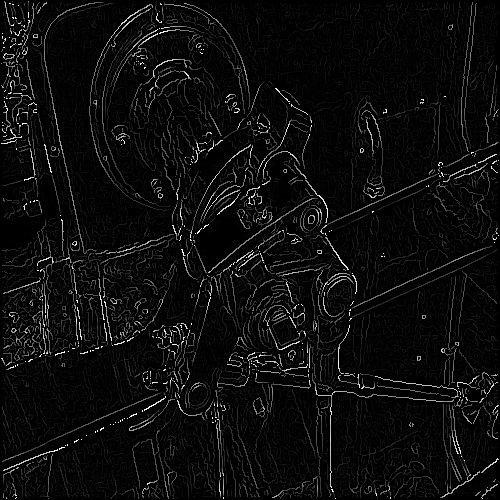

In [75]:
tmp.show_image_from_intensities(thinned)

In [84]:
class DoubleThresholding:
    '''
    Apply double thresholding to classify edges as strong, weak, or non-edges and apply edge tracking by hysteresis 
    '''
    def __init__(self, magnitudes, lower_threshold, upper_threshold):
        self.magnitudes = magnitudes
        self.lower = lower_threshold
        self.upper = upper_threshold

    def apply(self):
        '''
        Performs edge tracking by hysteresis
        '''
        strong = self.magnitudes >= self.upper
        weak = (self.magnitudes < self.upper) & (self.magnitudes >= self.lower)
        mapping = strong + weak*0.5
        return mapping

In [98]:
dt = DoubleThresholding(thinned,50,100)
maps = dt.apply()

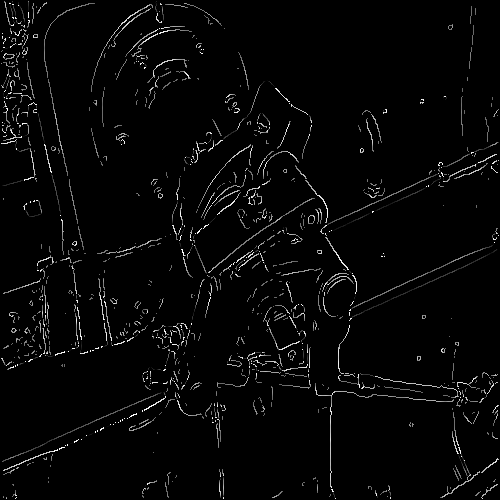

In [99]:
strong_edges = np.copy(thinned)
for i in range(len(thinned)):
    for j in range(len(thinned[0])):
        if maps[i][j] != 1:
            strong_edges[i][j] = 0
tmp.show_image_from_intensities(strong_edges)

In [130]:
class Hysteresis:
    '''
    Apply edge tracking via hysteresis
    '''
    def __init__(self, intensities, mapping):
        self.intensities
        self.mapping = mapping
    
    def _hysteresis(self):
        '''
        Promote weak edges (0.5) to strong if it is adjacent to a strong edge in the 8 directions
        '''
        row, col = self.mapping.shape
        dirs = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]
        for r in range(1,row-1):
            for c in range(1,col-1):
                if self.mapping[r][c] == 0.5:
                    for d in dirs:
                        if self.mapping[r+d[0]][c+d[1]] == 1:
                            self.mapping[r][c] = 1

    def apply(self):
        '''
        Apply edge tracking by hysteresis

        Returns the intensities of strong edges
        '''
        self._hysteresis()
        mapping = self.mapping == 1
        row, col = self.intensities.shape
        strong_edges = np.copy(self.intensities)
        for r in range(row):
            for c in range(col):
                if mapping[r][c] != 1:
                    strong_edges[r][c] = 0
        return strong_edges

In [110]:
hy = Hysteresis(maps)
mapping = hy.apply()

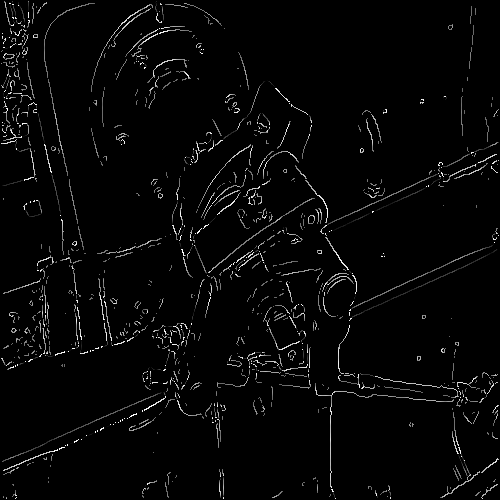

In [111]:
strong = np.copy(mapping)
for i in range(len(mapping)):
    for j in range(len(mapping[0])):
        if mapping[i][j] != 1:
            thinned[i][j] = 0
tmp.show_image_from_intensities(strong_edges)

In [133]:
class CannyEdgeDetector:
    def __init__(self, url, sigma=0.84049642, kernel_size=9, lower_threshold=50, upper_threshold=100):
        self.picture = Picture(url)
        self.picture.show_image()
        self.gaussian_blur = GaussianBlur(sigma, kernel_size)
        self.intensities = self.gaussian_blur.apply(self.picture)
        self.picture.show_image_from_intensities(self.intensities)
        self.gradient_calculator = GradientCalculator(self.intensities)
        magnitudes, angles = self.gradient_calculator.get_magnitudes_and_angles()
        self.nonmaximum_suppression = NonMaximumSuppression(magnitudes, angles)
        thinned = self.nonmaximum_suppression.apply_suppression()
        self.picture.show_image_from_intensities(thinned)
        self.double_thresholding = DoubleThresholding(thinned, lower_threshold, upper_threshold)
        mapping = self.double_thresholding.apply()
        self.hysteresis = Hysteresis(thinned, mapping)
        self.strong_edges = self.hysteresis.apply()
        self.picture.show_image_from_intensities(self.strong_edges)

    def apply(self):
        self.picture.show_image_from_intensities(self.strong_edges)


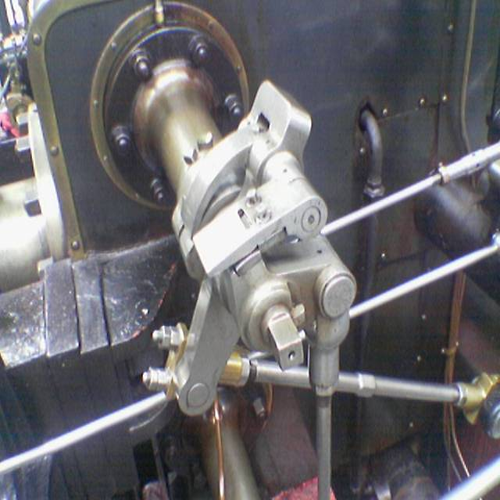

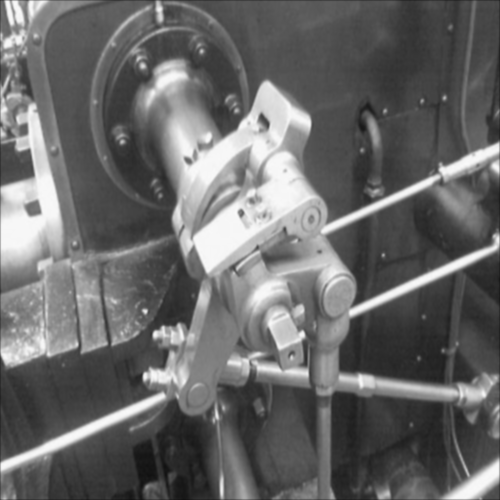

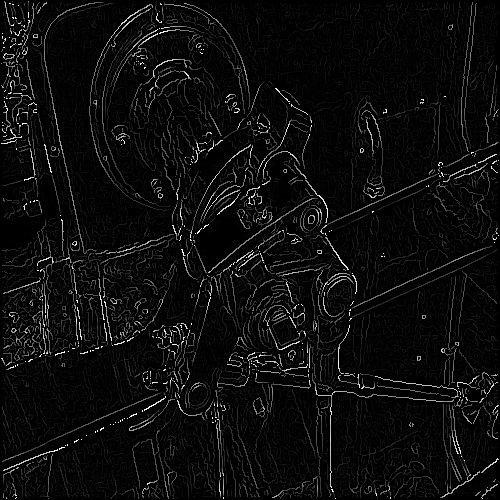

AttributeError: 'Hysteresis' object has no attribute 'intensities'

In [134]:
ced = CannyEdgeDetector('steam_valve.png')

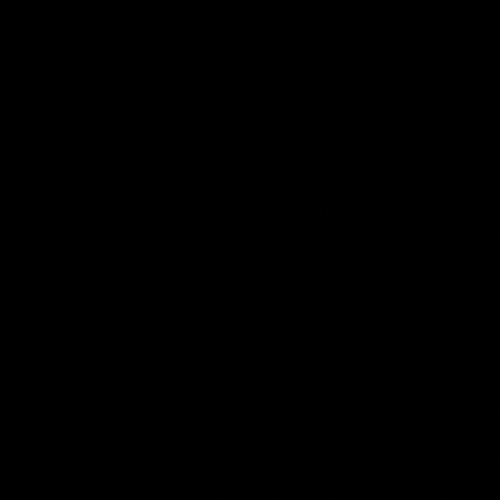

In [ ]:
ced.apply()